NLTK Basics

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('ggplot')

import nltk
nltk.download('averaged_perceptron_tagger')
nltk.download('maxent_ne_chunker')
nltk.download('words')
nltk.download('vader_lexicon')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\presh\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     C:\Users\presh\AppData\Roaming\nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     C:\Users\presh\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\presh\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [3]:
df = pd.read_csv('Reviews.csv')

In [4]:
df.shape

(568454, 10)

In [5]:
df = df.head(1000)

Quick EDA

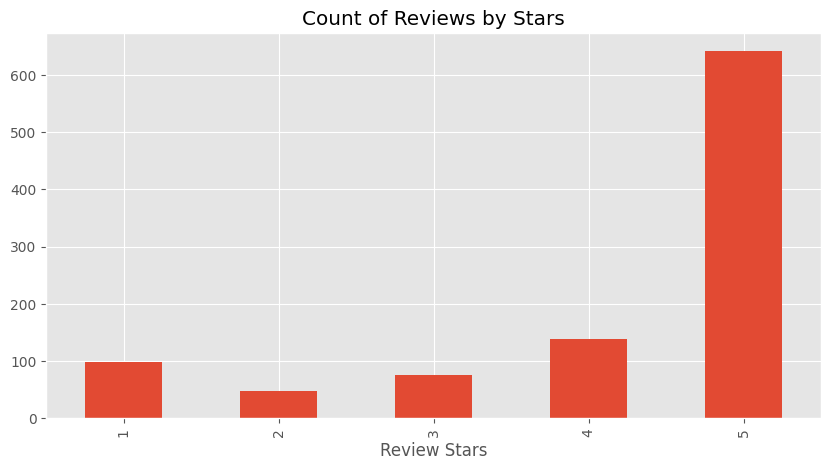

In [6]:
ax = df['Score'].value_counts().sort_index() \
    .plot(kind='bar',
          title='Count of Reviews by Stars',
          figsize=(10, 5))
ax.set_xlabel('Review Stars')
plt.show()

In [7]:
example = df['Text'][500]
example

"I bought these for the office and no one can put them down. I'm ordering more today and it has only been 2 weeks. Didn't have to shop for them either, Amazon brought it to my door!"

In [8]:
tokens = nltk.word_tokenize(example)
tokens[:10]

['I', 'bought', 'these', 'for', 'the', 'office', 'and', 'no', 'one', 'can']

In [9]:
tagged = nltk.pos_tag(tokens)
tagged[:10]

[('I', 'PRP'),
 ('bought', 'VBD'),
 ('these', 'DT'),
 ('for', 'IN'),
 ('the', 'DT'),
 ('office', 'NN'),
 ('and', 'CC'),
 ('no', 'DT'),
 ('one', 'NN'),
 ('can', 'MD')]

In [10]:
entities = nltk.chunk.ne_chunk(tagged)
entities.pprint()

(S
  I/PRP
  bought/VBD
  these/DT
  for/IN
  the/DT
  office/NN
  and/CC
  no/DT
  one/NN
  can/MD
  put/VB
  them/PRP
  down/RP
  ./.
  I/PRP
  'm/VBP
  ordering/VBG
  more/JJR
  today/NN
  and/CC
  it/PRP
  has/VBZ
  only/RB
  been/VBN
  2/CD
  weeks/NNS
  ./.
  Did/VBP
  n't/RB
  have/VB
  to/TO
  shop/VB
  for/IN
  them/PRP
  either/DT
  ,/,
  (PERSON Amazon/NNP)
  brought/VBD
  it/PRP
  to/TO
  my/PRP$
  door/NN
  !/.)


In [11]:
# VADER Sentiment Scoring

In [12]:
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm
sia = SentimentIntensityAnalyzer()

In [13]:
sia.polarity_scores('I am very very happy!')

{'neg': 0.0, 'neu': 0.397, 'pos': 0.603, 'compound': 0.6771}

In [14]:
sia.polarity_scores('This is worst case. I do not like it')

{'neg': 0.509, 'neu': 0.491, 'pos': 0.0, 'compound': -0.7359}

In [15]:
sia.polarity_scores(example)

{'neg': 0.067, 'neu': 0.887, 'pos': 0.046, 'compound': -0.2003}

In [16]:
res = {}
for i, row in tqdm(df.iterrows(), total = len(df)):
    text = row['Text']
    myid = row['Id']
    res[myid] = sia.polarity_scores(text)


  0%|          | 0/1000 [00:00<?, ?it/s]

In [17]:
vaders = pd.DataFrame(res).T
vaders = vaders.reset_index().rename(columns={'index': 'Id'})
vaders = vaders.merge(df, how='left')

In [18]:
vaders.head(3)

,Id,neg,neu,pos,compound,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,0.000,0.695,0.305,0.9441,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,0.138,0.862,0.000,-0.5664,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,0.091,0.754,0.155,0.8265,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


Plot VADER results

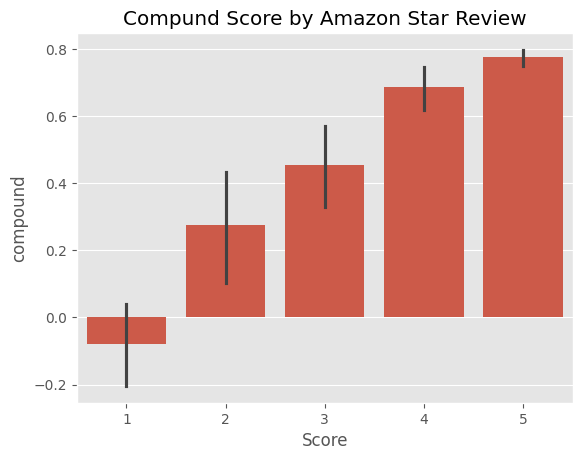

In [19]:
ax = sns.barplot(data=vaders, x='Score', y='compound')
ax.set_title('Compund Score by Amazon Star Review')
plt.show()

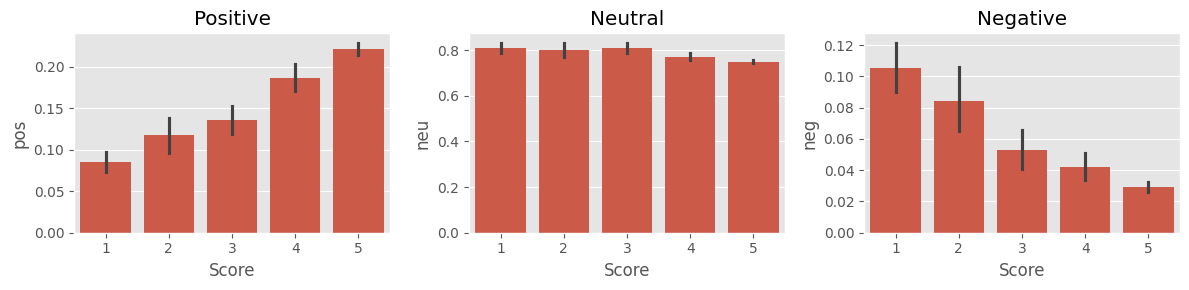

In [20]:
fig, axs = plt.subplots(1, 3, figsize=(12, 3))
sns.barplot(data=vaders, x='Score', y='pos', ax=axs[0])
sns.barplot(data=vaders, x='Score', y='neu', ax=axs[1])
sns.barplot(data=vaders, x='Score', y='neg', ax=axs[2])
axs[0].set_title('Positive')
axs[1].set_title('Neutral')
axs[2].set_title('Negative')
plt.tight_layout()
plt.show()

Roberta Pretrained Model

In [21]:
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax

In [22]:
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

In [23]:
print(example)
sia.polarity_scores(example)

I bought these for the office and no one can put them down. I'm ordering more today and it has only been 2 weeks. Didn't have to shop for them either, Amazon brought it to my door!


{'neg': 0.067, 'neu': 0.887, 'pos': 0.046, 'compound': -0.2003}

In [24]:
encoded_text = tokenizer(example, return_tensors='pt')
output = model(**encoded_text)
scores = output[0][0].detach().numpy()
scores = softmax(scores)
scores_dict = {
    'roberta_neg' : scores[0],
    'roberta_neu' : scores[1],
    'roberta_pos' : scores[2]
}
print(scores_dict)

{'roberta_neg': 0.0073193563, 'roberta_neu': 0.051132467, 'roberta_pos': 0.9415482}


In [25]:
def polarity_scores_roberta(example):
    encoded_text = tokenizer(example, return_tensors='pt')
    output = model(**encoded_text)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    scores_dict = {
        'roberta_neg' : scores[0],
        'roberta_neu' : scores[1],
        'roberta_pos' : scores[2]
    }
    return scores_dict

In [26]:
res = {}
for i, row in tqdm(df.iterrows(), total=len(df)):
    try:
        text = row['Text']
        myid = row['Id']
        vader_result = sia.polarity_scores(text)
        vader_result_rename = {}
        for key, value in vader_result.items():
            vader_result_rename[f"vader_{key}"] = value
        roberta_result = polarity_scores_roberta(text)
        both = {**vader_result_rename, **roberta_result}
        res[myid] = both
    except RuntimeError:
        print(f'Broke for id {myid}')

  0%|          | 0/1000 [00:00<?, ?it/s]

Broke for id 83
Broke for id 187
Broke for id 529
Broke for id 540
Broke for id 746
Broke for id 863


In [27]:
results_df = pd.DataFrame(res).T
results_df = results_df.reset_index().rename(columns={'index': 'Id'})
results_df = results_df.merge(df, how='left')

Compare Scores between models

In [28]:
results_df.columns

Index(['Id', 'vader_neg', 'vader_neu', 'vader_pos', 'vader_compound',
       'roberta_neg', 'roberta_neu', 'roberta_pos', 'ProductId', 'UserId',
       'ProfileName', 'HelpfulnessNumerator', 'HelpfulnessDenominator',
       'Score', 'Time', 'Summary', 'Text'],
      dtype='object')

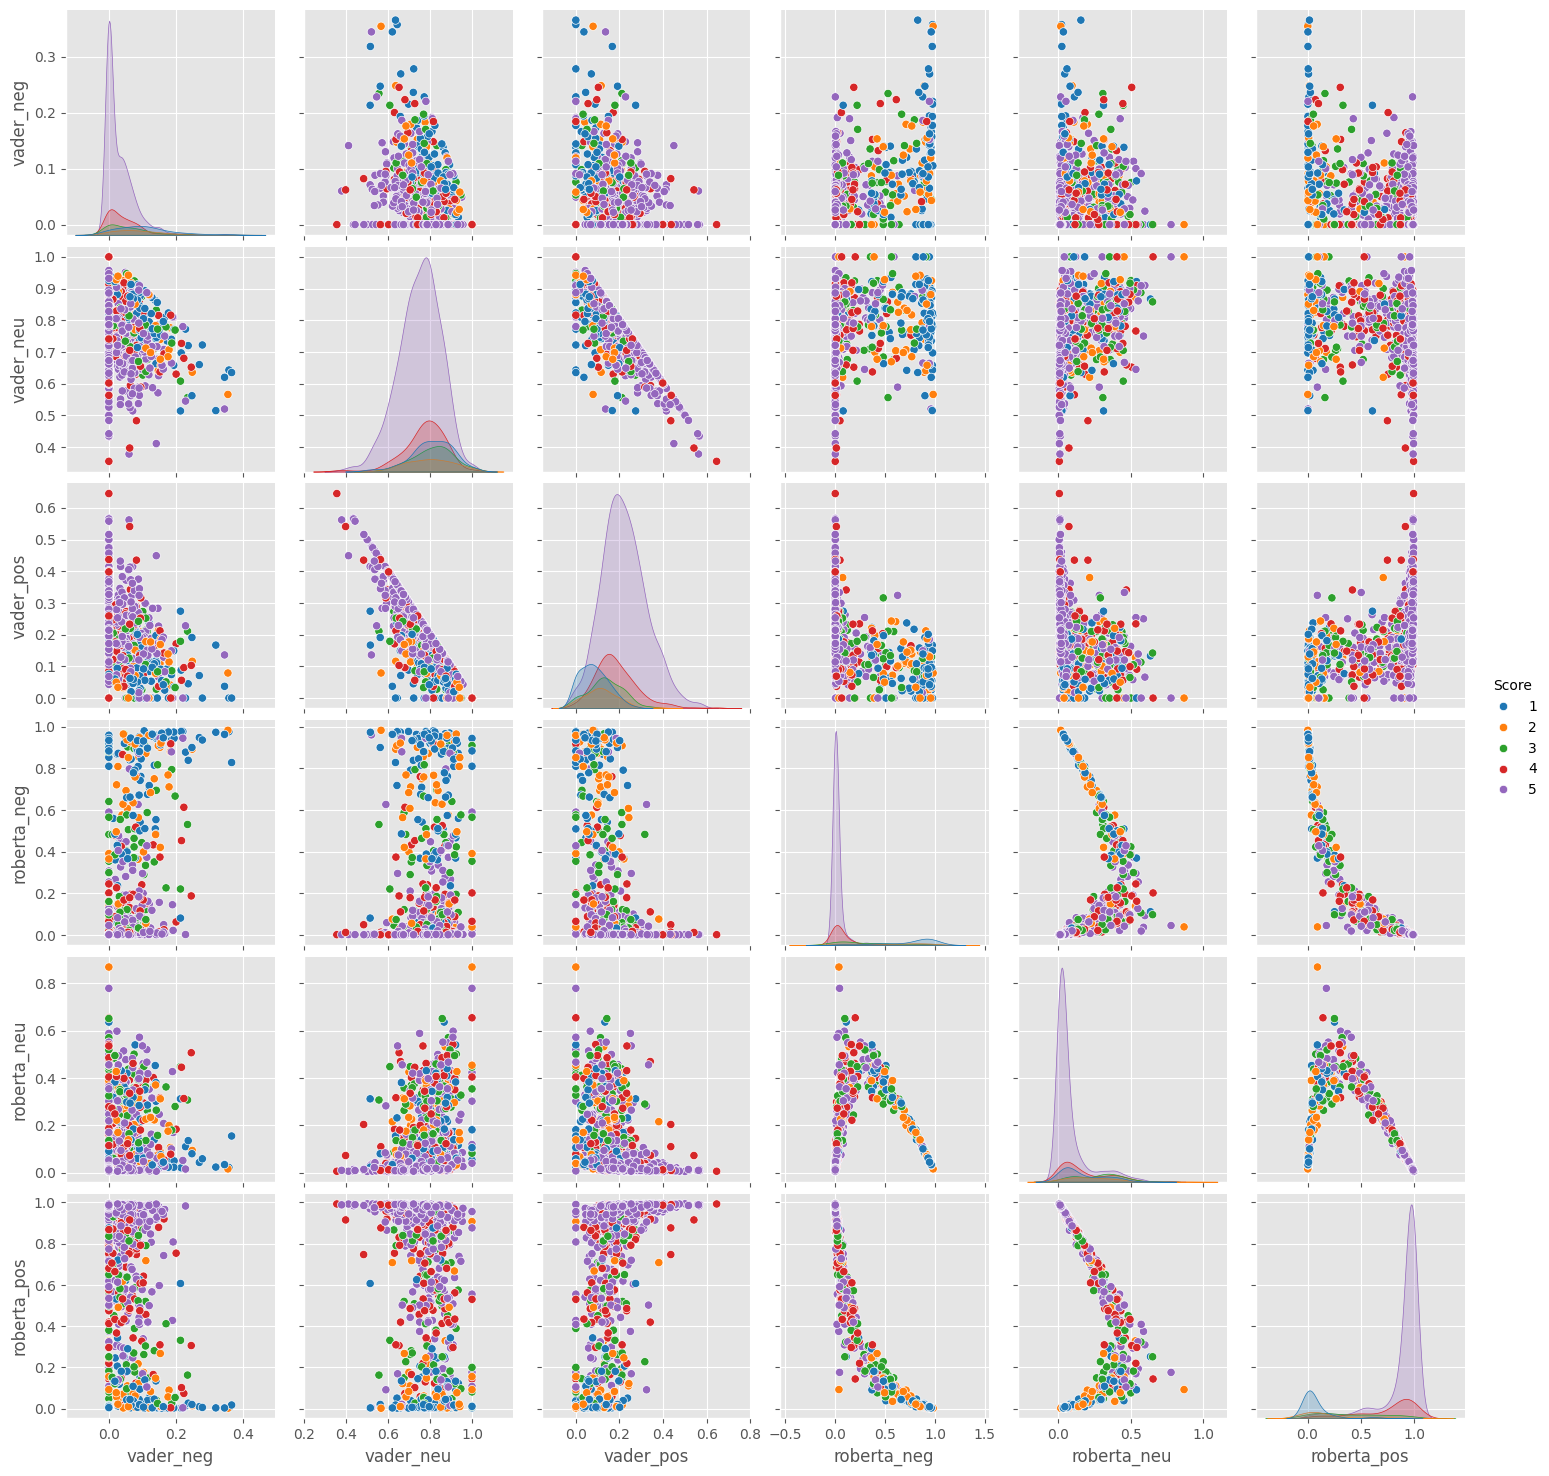

In [29]:
sns.pairplot(data=results_df,
             vars=['vader_neg', 'vader_neu', 'vader_pos',
                  'roberta_neg', 'roberta_neu', 'roberta_pos'],
            hue='Score',
            palette='tab10')
plt.show()

In [30]:
results_df.query('Score == 1') \
    .sort_values('roberta_pos', ascending=False)['Text'].values[0]

"I just wanted to post here that I found small bits of plastic in this food as I was feeding my 9 month old.  Plastic!!! in food!!!! baby food!!!  So please be careful if you buy this or are considering it.<br /><br />My daughter LOVES this food-- it's actually her favorite.  This is the first time we have noticed plastic in it in over 2 months."

In [31]:
results_df.query('Score == 1') \
    .sort_values('vader_pos', ascending=False)['Text'].values[0]

'So we cancelled the order.  It was cancelled without any problem.  That is a positive note...'

In [32]:
results_df.query('Score == 5') \
    .sort_values('roberta_neg', ascending=False)['Text'].values[0]

'this was sooooo deliscious but too bad i ate em too fast and gained 2 pds! my fault'

In [33]:
results_df.query('Score == 5') \
    .sort_values('vader_neg', ascending=False)['Text'].values[0]

'this was sooooo deliscious but too bad i ate em too fast and gained 2 pds! my fault'

The Transformers Pipeline

In [34]:
from transformers import pipeline

sent_pipeline = pipeline("sentiment-analysis")

No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


In [35]:
sent_pipeline('I love sentiment analysis!')

[{'label': 'POSITIVE', 'score': 0.9997853636741638}]

In [36]:
sent_pipeline('Pretty bad behaviour')

[{'label': 'NEGATIVE', 'score': 0.999797523021698}]

In [37]:
sent_pipeline('The movie was average ')

[{'label': 'NEGATIVE', 'score': 0.991671621799469}]